![portada](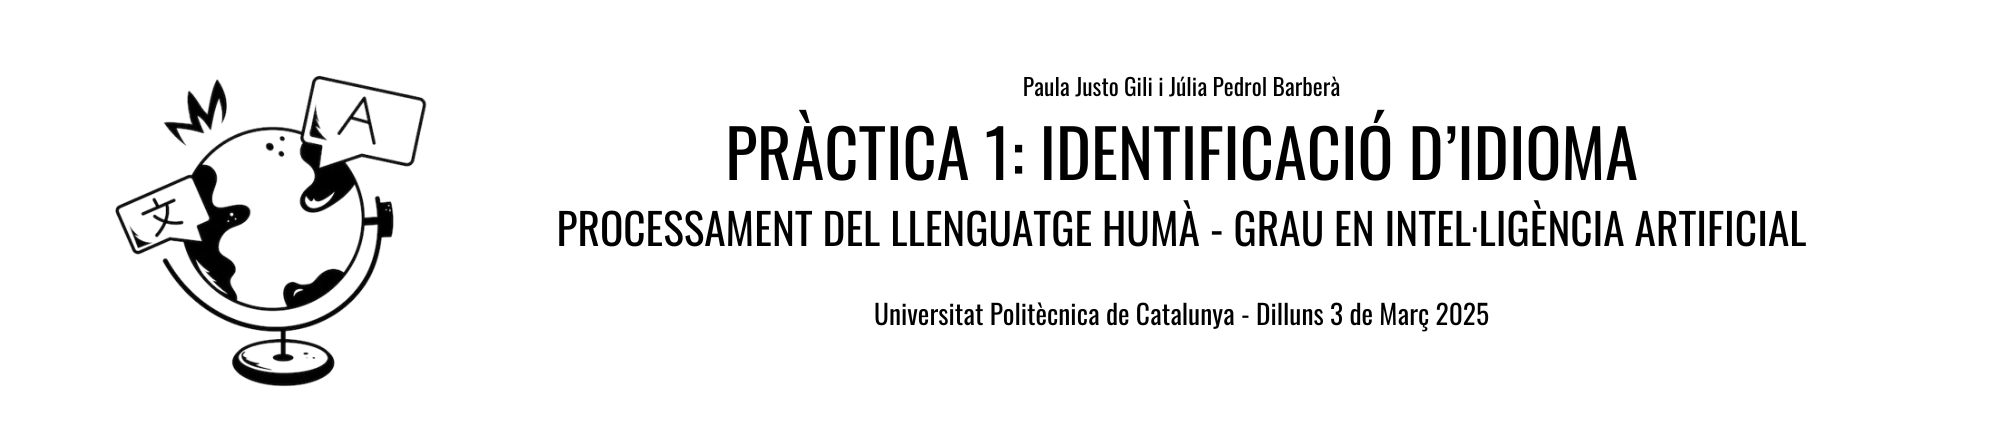
)

## **ÍNDEX**
- [INTRODUCCIÓ](#introducció)
- [LECTURA DE DADES](#lectura-de-dades)
    - [LECTURA DE DADES PEL CORPUS DE TRAIN](#lectura-de-dades-pel-corpus-de-train)
    - [LECTURA DE DADES PEL CORPUS DE TEST](#lectura-de-dades-pel-corpus-de-test)
- [PREPROCESSAMENT](#preprocessament)
    - [1. ELIMINACIÓ DE DIGITS](#1-eliminació-dels-dígits)
    - [2. TEXT EN MINÚSCULA](#2-text-en-minúscula)
    - [3. ESPAIS EN BLANC CONTINUS PER UN ÚNIC](#3-espais-en-blanc-continus-per-un-únic)
    - [4. CONCATENACIÓ D'ORACIONS](#4-concatenació-de-frases-amb-espai-doble)
- [CREACIÓ DE TRIGRAMS EN EL CORPUS DEL TRAIN](#creació-dels-trigrams-en-el-corpus-del-train)
- [FILTRATGE DELS TRIGRAMS](#filtratge-dels-trigrams)
- [TÈCNICA DE SUAVITZAT LIDSTONE](#tècnica-de-suavitzat-lidstone)
- [PREPROCESSAMENT DEL CORPUS DE TEST](#preprocessament-del-corpus-de-test)
- [CREACIÓ DELS TRIGRAMS EN EL CORPUS DEL TEST](#creació-dels-trigrams-en-el-corpus-de-test)
- [ANÀLISI DELS ERRORS EN LA CLASSIFICACIÓ D'IDIOMES](#anàlisi-dels-errors-en-la-classificació-didiomes)
    - [ORACIONS MAL CLASSIFICADES](#oracions-mal-classificades)
    - [DISTRIBUCIÓ DE CONFUSIÓ PER IDIOMA](#distribució-de-confusió-per-idioma)
    - [POSSIBLES MOTIUS PER LA CONFUSIÓ](#possibles-motius-per-la-confusió)
        - [1. TRIGRAMS COMUNS ENTRE IDIOMES](#1-trigrams-comuns-entre-idiomes)
        - [2. LONGITUD DE LES ORACIONS](#2-longitud-de-les-oracions)
        - [3. CLASSIFICACIONS INSEGURES](#3-classificacions-insegures)
- [CONCLUSIONS DE L'ANÀLISI DELS ERRORS EN LA CLASSIFIACIÓ D'IDIOMES](#conclusions-de-lanàlisi-dels-errors-en-la-classifiació-didiomes)        


## **INTRODUCCIÓ**
---
<p style="text-align: justify;">
En aquesta pràctica desenvoluparem un sistema d’identificació d’idioma basat en trigrames de caràcters per a sis llengües europees (anglès, espanyol, alemany, neerlandès, francès i italià). El nostre objectiu és determinar l'idioma de cada frase del conjunt de test, identificant-lo mitjançant el càlcul de la probabilitat logarítmica segons els models que hem entrenat a partir del train.

Per a l'entrenament dels models lingüístics, hem aplicat la tècnica de suavització LID per gestionar el problema dels trigrames no observats i hem filtrat els trigrames amb una freqüència menor que 5. En canvi, en el conjunt de test, hem generat els trigrames sense aplicar-hi ni el suavitzat ni filtratge per freqüència.

La metodologia que hem seguit consisteix a calcular la probabilitat logarítmica de cada frase del test respecte a cadascun dels models d’idioma. L’idioma que assignarem a cada frase serà aquell que obtingui la probabilitat més alta. Cal destacar que hem considerat la frase com la unitat mínima d’identificació, delimitada per ". " (punt seguit de dos espais).

Finalment, generarem una matriu de confusió per avaluar el rendiment del sistema, en la qual, si la classificació és perfecta disposarem d'una matriu diagonal amb aproximadament 10.000 frases per idioma a la diagonal, corresponent al total de frases del test per a cada llengua.
</p>

## **LECTURA DE DADES**
---

### **LECTURA DE DADES PEL CORPUS DE TRAIN** 

In [50]:
raw_train_en = 'eng_trn.txt'
raw_train_sp = 'spa_trn.txt'
raw_train_ger = 'deu_trn.txt'
raw_train_it = 'ita_trn.txt'
raw_train_ner = 'nld_trn.txt'
raw_train_fr = 'fra_trn.txt'

In [51]:
# Funció per llegir un fitxer
def read_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        return text
    except FileNotFoundError:
        print(f"El fitxer {file_path} no s'ha trobat.")
        return None

train_en_text = read_file(raw_train_en)
train_sp_text = read_file(raw_train_sp)
train_ger_text = read_file(raw_train_ger)
train_it_text = read_file(raw_train_it)
train_ner_text = read_file(raw_train_ner)
train_fr_text = read_file(raw_train_fr)

In [52]:
print(f"\033[1mAnglès (mostra):\033[0m\n{train_en_text[:500]}\n")
print(f"\033[1mEspanyol (mostra):\033[0m\n{train_sp_text[:500]}\n")
print(f"\033[1mAlemany (mostra):\033[0m\n{train_ger_text[:500]}\n")
print(f"\033[1mItalià (mostra):\033[0m\n{train_it_text[:500]}\n")
print(f"\033[1mNeerlandès (mostra):\033[0m\n{train_ner_text[:500]}\n")
print(f"\033[1mFrancès (mostra):\033[0m\n{train_fr_text[:500]}\n")

Anglès (mostra):
1	• • •
2	0.00 0.00% How the mighty have fallen.
3	0.00 0.00% Major companies coming out with their latest quarterly numbers include Dave & Buster's, Men's Wearhouse, Palo Alto Networks, Box, Barnes & Noble, Pep Boys-Manny, Moe & Jack, Ollie's Bargain Outlet, DavidsTea, Lululemon Athletica and Kroger.
4	01 JANUARY 2015, MAGAZINE Why are there so many Magna Cartas?
5	0:44 Now watching Up next 2016 Word Association with Brad Woodhouse The president of the Democratic American Bridge PAC on the GOP 

Espanyol (mostra):
1	Denuncia IEM probable fraude con actas electorales El Instituto Electoral de Michoacán denunció ante la Fiscalía Especializada la presencia de actas de escrutinio y cómputo, al parecer apócrifas, en un taller de impresión ricardo.
2	A pesar de la organización del movimiento, su paisano, Abelande, critica la dispersión de las propuestas.
3	Es decir, el BM entrega préstamos (evidentemente con elevados intereses que engrosan la deuda externa letal de los Esta

### **LECTURA DE DADES PEL CORPUS DE TEST**

In [53]:
raw_test_en = 'eng_tst.txt'
raw_test_sp = 'spa_tst.txt'
raw_test_ger = 'deu_tst.txt'
raw_test_it = 'ita_tst.txt'
raw_test_ner = 'nld_tst.txt'
raw_test_fr = 'fra_tst.txt'

In [54]:
# Funció per llegir un fitxer
def read_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        return text
    except FileNotFoundError:
        print(f"El fitxer {file_path} no s'ha trobat.")
        return None

test_en_text = read_file(raw_test_en)
test_sp_text = read_file(raw_test_sp)
test_ger_text = read_file(raw_test_ger)
test_it_text = read_file(raw_test_it)
test_ner_text = read_file(raw_test_ner)
test_fr_text = read_file(raw_test_fr)

In [55]:
print(f"\033[1mAnglès (mostra):\033[0m\n{test_en_text[:500]}\n")
print(f"\033[1mEspanyol (mostra):\033[0m\n{test_sp_text[:500]}\n")
print(f"\033[1mAlemany (mostra):\033[0m\n{test_ger_text[:500]}\n")
print(f"\033[1mItalià (mostra):\033[0m\n{test_it_text[:500]}\n")
print(f"\033[1mNeerlandès (mostra):\033[0m\n{test_ner_text[:500]}\n")
print(f"\033[1mFrancès (mostra):\033[0m\n{test_fr_text[:500]}\n")

Anglès (mostra):
1	0:49 autoplay autoplay Copy this code to your website or blog MOSCOW — Timur the goat was meant to be nothing more than a tasty meal for Amur, a Siberian tiger living in a safari park.
2	08:35 GMT - Roadmap signed - The head of the UN atomic watchdog says Iran has signed a "roadmap" for probing suspected efforts to develop nuclear weapons, a key part of an overall accord with major powers.
3	100 moments from the Iraq War 100 photos A boy stands at the scene of a car bombing in front of the Sha

Espanyol (mostra):
1	Denuncia IEM probable fraude con actas electorales El Instituto Electoral de Michoacán denunció ante la Fiscalía Especializada la presencia de actas de escrutinio y cómputo, al parecer apócrifas, en un taller de impresión ricardo.
2	A pesar de la organización del movimiento, su paisano, Abelande, critica la dispersión de las propuestas.
3	Es decir, el BM entrega préstamos (evidentemente con elevados intereses que engrosan la deuda externa letal de los Esta

## **PREPROCESSAMENT**
---

<p style="text-align: justify;">
Per tal de fer el preprocessament dels textos i preparar-los per la posterior identificació de l'idioma hem realitzat els següents passos de preprocessat:

- **Eliminació de dígits:** Suprimirem tots els números del text per evitar que afectin l'anàlisi lingüística.

- **Conversió a minúscules:** Transformarem tot el text a minúscules per assegurar la coherència en la generació de trigrames.

- **Normalització d'espais en blanc:** Substituirem els espais en blanc continus per un de sol, exceptuant els punts i a part per preservar la separació entre frases.

- **Concatenació de línies:** Concatenarem les línies separades per un salt de línia amb dos espais ('.  ') per marcar correctament els punts i a part, és a dir, les diferents oracions, que considerem com unitat mínim d'identificació per veure si pertanyen o no a un cert idioma.
<p>

### **1. ELIMINACIÓ DELS DÍGITS**

In [56]:
# Funció per eliminar dígits
def elimina_digits(text):
    text_sense_digits = ''.join([char for char in text if not char.isdigit()])
    return text_sense_digits

La funció `eliminar_digits(text)` té com a objectiu eliminar tots els dígits presents en una cadena de text. Per aconseguir-ho, revisa cada caràcter del text i verifica si és un dígit. Si ho és, el caràcter es retira, mentre que els altres caràcters es mantenen.

In [57]:
train_no_digit_en = elimina_digits(train_en_text)
train_no_digit_sp = elimina_digits(train_sp_text)
train_no_digit_ger = elimina_digits(train_ger_text)
train_no_digit_it = elimina_digits(train_it_text)
train_no_digit_ner = elimina_digits(train_ner_text)
train_no_digit_fr = elimina_digits(train_fr_text)

In [58]:
print(f"\033[1mAnglès (mostra):\033[0m\n{train_no_digit_en[:500]}\n")
print(f"\033[1mEspanyol (mostra):\033[0m\n{train_no_digit_sp[:500]}\n") 
print(f"\033[1mAlemany (mostra):\033[0m\n{train_no_digit_ger[:500]}\n")
print(f"\033[1mItalià (mostra):\033[0m\n{train_no_digit_it[:500]}\n")
print(f"\033[1mNeerlandès (mostra):\033[0m\n{train_no_digit_ner[:500]}\n")
print(f"\033[1mFrancès (mostra):\033[0m\n{train_no_digit_fr[:500]}\n")

Anglès (mostra):
	• • •
	. .% How the mighty have fallen.
	. .% Major companies coming out with their latest quarterly numbers include Dave & Buster's, Men's Wearhouse, Palo Alto Networks, Box, Barnes & Noble, Pep Boys-Manny, Moe & Jack, Ollie's Bargain Outlet, DavidsTea, Lululemon Athletica and Kroger.
	 JANUARY , MAGAZINE Why are there so many Magna Cartas?
	: Now watching Up next  Word Association with Brad Woodhouse The president of the Democratic American Bridge PAC on the GOP presidential field.
	: autopla

Espanyol (mostra):
	Denuncia IEM probable fraude con actas electorales El Instituto Electoral de Michoacán denunció ante la Fiscalía Especializada la presencia de actas de escrutinio y cómputo, al parecer apócrifas, en un taller de impresión ricardo.
	A pesar de la organización del movimiento, su paisano, Abelande, critica la dispersión de las propuestas.
	Es decir, el BM entrega préstamos (evidentemente con elevados intereses que engrosan la deuda externa letal de los Estados

### **2. TEXT EN MINÚSCULA**

In [59]:
# Funció per convertir el text a minúscules
def converteix_minuscules(text):
    text_minuscules = text.lower()
    return text_minuscules

La finalitat de la funció `converteix_minuscules(text)` és passar tot el text a minúscules. Per fer-ho, utilitza el mètode *lower()*, que converteix totes les lletres majúscules del text en minúscules. L'aplicació d'aquesta ens permet garantir coherència i evitar distincions innecessàries entre majúscules i minúscules. 

In [60]:
train_minuscules_en = converteix_minuscules(train_no_digit_en)
train_minuscules_sp = converteix_minuscules(train_no_digit_sp)
train_minuscules_ger = converteix_minuscules(train_no_digit_ger)
train_minuscules_it = converteix_minuscules(train_no_digit_it)
train_minuscules_ner = converteix_minuscules(train_no_digit_ner)
train_minuscules_fr = converteix_minuscules(train_no_digit_fr)

In [61]:
print(f"\033[1mAnglès (mostra):\033[0m\n{train_minuscules_en[:500]}\n")
print(f"\033[1mEspanyol (mostra):\033[0m\n{train_minuscules_sp[:500]}\n")
print(f"\033[1mAlemany (mostra):\033[0m\n{train_minuscules_ger[:500]}\n")
print(f"\033[1mItalià (mostra):\033[0m\n{train_minuscules_it[:500]}\n")
print(f"\033[1mNeerlandès (mostra):\033[0m\n{train_minuscules_ner[:500]}\n")
print(f"\033[1mFrancès (mostra):\033[0m\n{train_minuscules_fr[:500]}\n")

Anglès (mostra):
	• • •
	. .% how the mighty have fallen.
	. .% major companies coming out with their latest quarterly numbers include dave & buster's, men's wearhouse, palo alto networks, box, barnes & noble, pep boys-manny, moe & jack, ollie's bargain outlet, davidstea, lululemon athletica and kroger.
	 january , magazine why are there so many magna cartas?
	: now watching up next  word association with brad woodhouse the president of the democratic american bridge pac on the gop presidential field.
	: autopla

Espanyol (mostra):
	denuncia iem probable fraude con actas electorales el instituto electoral de michoacán denunció ante la fiscalía especializada la presencia de actas de escrutinio y cómputo, al parecer apócrifas, en un taller de impresión ricardo.
	a pesar de la organización del movimiento, su paisano, abelande, critica la dispersión de las propuestas.
	es decir, el bm entrega préstamos (evidentemente con elevados intereses que engrosan la deuda externa letal de los estados

### **3. ESPAIS EN BLANC CONTINUS PER UN ÚNIC**

In [62]:
import re

# Funció per substituir espais en blanc continus per un de sol
def substitueix_espais(text):
    text_net = re.sub('(  +|\t+)', ' ', text)
    return text_net

La funció `substitueix_espai(text)` substitueix tots els espais en blanc consecutius per un únic espai. Per aconseguir-ho, utilitza *re.sub()* del mòdul *re*, que permet identificar i substituir patrons en el text de manera eficient.

Concretament, aquesta funció cerca:
- Espais múltiples ( +)
- Caràcters de tabulació (\t+), els quals els trobaven a l'inici de les oracions.


Per tant, el que fa és, quan detecta algun d’aquests patrons, els substitueix per un únic espai, garantint que el text netegi de manera ràpida i consistent gràcies a les expressions regulars.

In [63]:
train_espais_en = substitueix_espais(train_minuscules_en)
train_espais_sp = substitueix_espais(train_minuscules_sp)
train_espais_ger = substitueix_espais(train_minuscules_ger)
train_espais_it = substitueix_espais(train_minuscules_it)
train_espais_ner = substitueix_espais(train_minuscules_ner)
train_espais_fr = substitueix_espais(train_minuscules_fr)

In [64]:
print(f"\033[1mAnglès (mostra):\033[0m\n{train_espais_en[:500]}\n")
print(f"\033[1mEspanyol (mostra):\033[0m\n{train_espais_sp[:500]}\n")
print(f"\033[1mAlemany (mostra):\033[0m\n{train_espais_ger[:500]}\n")
print(f"\033[1mItalià (mostra):\033[0m\n{train_espais_it[:500]}\n")
print(f"\033[1mNeerlandès (mostra):\033[0m\n{train_espais_ner[:500]}\n")
print(f"\033[1mFrancès (mostra):\033[0m\n{train_espais_fr[:500]}\n")

Anglès (mostra):
 • • •
 . .% how the mighty have fallen.
 . .% major companies coming out with their latest quarterly numbers include dave & buster's, men's wearhouse, palo alto networks, box, barnes & noble, pep boys-manny, moe & jack, ollie's bargain outlet, davidstea, lululemon athletica and kroger.
  january , magazine why are there so many magna cartas?
 : now watching up next word association with brad woodhouse the president of the democratic american bridge pac on the gop presidential field.
 : autoplay

Espanyol (mostra):
 denuncia iem probable fraude con actas electorales el instituto electoral de michoacán denunció ante la fiscalía especializada la presencia de actas de escrutinio y cómputo, al parecer apócrifas, en un taller de impresión ricardo.
 a pesar de la organización del movimiento, su paisano, abelande, critica la dispersión de las propuestas.
 es decir, el bm entrega préstamos (evidentemente con elevados intereses que engrosan la deuda externa letal de los estados

### **4. CONCATENACIÓ DE FRASES AMB ESPAI DOBLE**

In [65]:
# Funció per concatenar línies amb dos espais només quan hi ha punts i a part (punt seguit d'un salt de línia)
def concatenar_amb_espai_doble(text):
    linies = text.split('\n')
    linies = [linia.strip() + '.' if linia and not linia.strip().endswith('.') else linia.strip() for linia in linies if linia.strip()]
    text_concatenat = '  '.join(linies)
    return text_concatenat.strip()

Aquesta funció, `concatenar_amb_espai_doble(text)`, té com a objectiu concatenar les frases d’un text utilitzant un punt i dos espais (.  ) per indicar punts i a part.

El seu funcionament es basa en tres passos principals:
1. Divisió per línies: El text es divideix en una llista de frases a partir dels salts de línia (\\n).
2. Filtrat i normalització: S’eliminen les línies buides i es revisa que cada línia acabi amb un punt. Si alguna no en té, se li afegeix per assegurar que totes les frases quedin ben separades i tinguin un final diferenciable.
3. Concatenació amb dos espais: Finalment, les línies es concatenen utilitzant dos espais per simular la separació pròpia d’un punt i a part, mantenint així la coherència estructural del text i posteriorment, tenir més facilitats davant la diferenciació entre frases.

Aquesta funció és especialment útil per preparar el text abans del processament, assegurant que la separació entre frases es manté clara i coherent.

In [66]:
train_concatenat_en = concatenar_amb_espai_doble(train_espais_en)
train_concatenat_sp = concatenar_amb_espai_doble(train_espais_sp)
train_concatenat_ger = concatenar_amb_espai_doble(train_espais_ger)
train_concatenat_it = concatenar_amb_espai_doble(train_espais_it)
train_concatenat_ner = concatenar_amb_espai_doble(train_espais_ner)
train_concatenat_fr = concatenar_amb_espai_doble(train_espais_fr)

In [67]:
print(f"\033[1mAnglès (mostra):\033[0m\n{train_concatenat_en[:500]}\n")
print(f"\033[1mEspanyol (mostra):\033[0m\n{train_concatenat_sp[:500]}\n")
print(f"\033[1mAlemany (mostra):\033[0m\n{train_concatenat_ger[:500]}\n")
print(f"\033[1mItalià (mostra):\033[0m\n{train_concatenat_it[:500]}\n")
print(f"\033[1mNeerlandès (mostra):\033[0m\n{train_concatenat_ner[:500]}\n")
print(f"\033[1mFrancès (mostra):\033[0m\n{train_concatenat_fr[:500]}\n")

Anglès (mostra):
• • •.  . .% how the mighty have fallen.  . .% major companies coming out with their latest quarterly numbers include dave & buster's, men's wearhouse, palo alto networks, box, barnes & noble, pep boys-manny, moe & jack, ollie's bargain outlet, davidstea, lululemon athletica and kroger.  january , magazine why are there so many magna cartas?.  : now watching up next word association with brad woodhouse the president of the democratic american bridge pac on the gop presidential field.  : autoplay

Espanyol (mostra):
denuncia iem probable fraude con actas electorales el instituto electoral de michoacán denunció ante la fiscalía especializada la presencia de actas de escrutinio y cómputo, al parecer apócrifas, en un taller de impresión ricardo.  a pesar de la organización del movimiento, su paisano, abelande, critica la dispersión de las propuestas.  es decir, el bm entrega préstamos (evidentemente con elevados intereses que engrosan la deuda externa letal de los estados)

## **CREACIÓ DELS TRIGRAMS EN EL CORPUS DEL TRAIN**
---

In [68]:
# Instal·lació dels paquets necessaris
%pip install --user -U nltk
%pip install --user -U numpy
%pip install svgling

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [69]:
import nltk
from nltk.collocations import TrigramCollocationFinder

In [70]:
# Creació dels trigrames per cada idioma en els seus respectius textos de train

trig_train_en = TrigramCollocationFinder.from_words(train_concatenat_en)
trigrames_train_en = [tr for tr in trig_train_en.ngram_fd.items()]

trig_train_sp = TrigramCollocationFinder.from_words(train_concatenat_sp)
trigrames_train_sp = [tr for tr in trig_train_sp.ngram_fd.items()]

trig_train_ger = TrigramCollocationFinder.from_words(train_concatenat_ger)
trigrames_train_ger = [tr for tr in trig_train_ger.ngram_fd.items()]

trig_train_it = TrigramCollocationFinder.from_words(train_concatenat_it)
trigrames_train_it = [tr for tr in trig_train_it.ngram_fd.items()]

trig_train_ner = TrigramCollocationFinder.from_words(train_concatenat_ner)
trigrames_train_ner = [tr for tr in trig_train_ner.ngram_fd.items()]

trig_train_fr = TrigramCollocationFinder.from_words(train_concatenat_fr)
trigrames_train_fr = [tr for tr in trig_train_fr.ngram_fd.items()]


Per generar els trigrames dels textos  del train, hem utilitzat el mètode explicat a classe, basat en la utilització de `TrigramCollocationFinder` de la llibreria *nltk*. Aquest mètode ens permet extreure de manera eficient tots els trigrames d’un text i obtenir-ne la seva freqüència.
Mitjançant l'aplicació d'aquest mètode, per a cada idioma del conjunt d’entrenament, hem generant una llista de trigrames juntament amb la seva freqüència. Hem optat per aquesta aplicació ja que ens proporciona una representació clara de quins trigrames són més comuns en cada idioma, cosa que resulta essencial per a la classificació posterior i, a més a més, ens permet tenir un control de la frqüència de cada un d'ells.

## **FILTRATGE DELS TRIGRAMS**
---

In [71]:
from collections import Counter

freq_trig_train_en = Counter(dict(trig_train_en.ngram_fd.items()))
freq_trig_train_sp = Counter(dict(trig_train_sp.ngram_fd.items()))
freq_trig_train_ger = Counter(dict(trig_train_ger.ngram_fd.items()))
freq_trig_train_it = Counter(dict(trig_train_it.ngram_fd.items()))
freq_trig_train_ner = Counter(dict(trig_train_ner.ngram_fd.items()))
freq_trig_train_fr = Counter(dict(trig_train_fr.ngram_fd.items()))

#Funció per filtrar els trigrams ≥ 5
def filtra_trigrames(freq_trigrames, min_freq=5):
    return {trigram: freq for trigram, freq in freq_trigrames.items() if freq >= min_freq}

freq_trig_train_en = filtra_trigrames(freq_trig_train_en)
freq_trig_train_sp = filtra_trigrames(freq_trig_train_sp)
freq_trig_train_ger = filtra_trigrames(freq_trig_train_ger)
freq_trig_train_it = filtra_trigrames(freq_trig_train_it)
freq_trig_train_ner = filtra_trigrames(freq_trig_train_ner)
freq_trig_train_fr = filtra_trigrames(freq_trig_train_fr)

El filtratge dels trigrams consisteix en quedar-nos únicament amb els que tenen una freqüència més gran o igual que 5, és a dir, apareixen almenys 5 cops en el text. Hem utilitzat la classe *Counter* per convertir els trigrams generats per a cada idioma en un diccionari que emmagatzema la freqüència d’aparició de cada trigram.

A continuació, hem definit la funció `filtra_trigrames(freq_trigrames, min_freq=5)`, que filtra i conserva únicament aquells trigrames que apareixen com a mínim cinc vegades (min_freq = 5). Aquesta funció ens permet eliminar trigrames poc freqüents que podrien no ser representatius per a la classificació, centrant-nos només en els trigrames més rellevants i comuns per a cada idioma.

## **TÈCNICA DE SUAVITZAT: LIDSTONE**
---

In [72]:
#  Funció per aplicar el suavitzat de Lidstone
def suavitzat_lidstone(freq_trigrames, lambda_valor=0.5):
    N_T = sum(freq_trigrames.values())  # Total de trigrames
    B = len(freq_trigrames)  # Nombre de trigrames únics

    prob_suavitzades = {
        trigram: (freq + lambda_valor) / (N_T + lambda_valor * B)
        for trigram, freq in freq_trigrames.items()
    }

    return prob_suavitzades

prob_trigrams_train_en = suavitzat_lidstone(freq_trig_train_en)
prob_trigrams_train_sp = suavitzat_lidstone(freq_trig_train_sp)
prob_trigrams_train_ger = suavitzat_lidstone(freq_trig_train_ger)
prob_trigrams_train_it = suavitzat_lidstone(freq_trig_train_it)
prob_trigrams_train_ner = suavitzat_lidstone(freq_trig_train_ner)
prob_trigrams_train_fr = suavitzat_lidstone(freq_trig_train_fr)


models_train = {
    "anglès": prob_trigrams_train_en,
    "espanyol": prob_trigrams_train_sp,
    "alemany": prob_trigrams_train_ger,
    "italià": prob_trigrams_train_it,
    "neerlandès": prob_trigrams_train_ner,
    "francès": prob_trigrams_train_fr
}

Hem aplicat la tècnica de suavització de Lidstone (LID) per evitar que els trigrames no observats tinguin una probabilitat zero, és a dir, per eivtar que els trigrames que no apareixen al text se'ls hi assigni 0 coma valor de probabilitat. Aquest factor és essencial per garantir una classificació robusta. 
Aquesta tècnica calcula la probabilitat de cada trigram mitjançant la fórmula:
$$
P(trigrama) = \frac{\text{freq(trigrama)} + \lambda}{N_T + \lambda \times B}
$$

Hem escollit un valor de **λ = 0,5** ja que ens permet donar una mica de pes als trigrames que no apareixen al conjunt obtingut mitjançant les bases de textos del train, sense que això afecti massa la importància dels trigrames que sí que són comuns i estan presents. D’aquesta manera, el model pot gestionar millor nous trigrames sense perdre la informació rellevant dels més freqüents. 

Pel que fa al valor de **B**, hem considerat el nombre total de trigrames únics per a cada idioma. Aquesta elecció és coherent amb el nivell de detall del model, ja que treballem amb trigrames. Si haguéssim treballat amb paraules, B hauria correspost al total de paraules úniques del diccionari.

Aquesta aproximació ens ajuda a tenir models més fiables, capaços de classificar els idiomes de manera encertada fins i tot quan es troben amb trigrames que no havien aparegut durant l’entrenament.

## **PREPROCESSAMENT DEL CORPUS DE TEST**
---

In [73]:
# 1. Preprocessar els textos de test

# 1.1. Eliminar digits
test_no_digit_en = elimina_digits(test_en_text)
test_no_digit_sp = elimina_digits(test_sp_text)
test_no_digit_ger = elimina_digits(test_ger_text)
test_no_digit_it = elimina_digits(test_it_text)
test_no_digit_ner = elimina_digits(test_ner_text)
test_no_digit_fr = elimina_digits(test_fr_text)

# 1.2. Convertir a minúscules
test_minuscules_en = converteix_minuscules(test_no_digit_en)
test_minuscules_sp = converteix_minuscules(test_no_digit_sp)
test_minuscules_ger = converteix_minuscules(test_no_digit_ger)
test_minuscules_it = converteix_minuscules(test_no_digit_it)
test_minuscules_ner = converteix_minuscules(test_no_digit_ner)
test_minuscules_fr = converteix_minuscules(test_no_digit_fr)

# 1.3. Substituir espais en blanc continus
test_espais_en = substitueix_espais(test_minuscules_en)
test_espais_sp = substitueix_espais(test_minuscules_sp)
test_espais_ger = substitueix_espais(test_minuscules_ger)
test_espais_it = substitueix_espais(test_minuscules_it)
test_espais_ner = substitueix_espais(test_minuscules_ner)
test_espais_fr = substitueix_espais(test_minuscules_fr)

# 1.4. Concatenar frases
test_concatenat_en = concatenar_amb_espai_doble(test_espais_en)
test_concatenat_sp = concatenar_amb_espai_doble(test_espais_sp)
test_concatenat_ger = concatenar_amb_espai_doble(test_espais_ger)
test_concatenat_it = concatenar_amb_espai_doble(test_espais_it)
test_concatenat_ner = concatenar_amb_espai_doble(test_espais_ner)
test_concatenat_fr = concatenar_amb_espai_doble(test_espais_fr)

Després d’haver entrenat el model amb els corpus del train, hem aplicat el mateix preprocessament als corpus del test, utilitzant les funcions definides prèviament. Així, hem preparat els corpus del test per a la seva posterior anàlisi i identificació de l’idioma, assegurant que es mantinguin les mateixes condicions que en l’entrenament i garantint la coherència dels resultats.

Volem remarcar que en aquest cas, només hem preprocessat els textos del test, sense realitzar cap entrenament del model ni aplicar filtrat per freqüència o la tècnica de suavització. Això ho hem fet així, ja que considerem que l’objectiu de la pràctica és que el test serveixi exclusivament per avaluar el rendiment del model ja entrenat, sense influir en la seva configuració.

## **CREACIÓ DELS TRIGRAMS EN EL CORPUS DE TEST**
---

In [74]:
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Funció per generar els trigrames en ordre
def genera_trigrames_en_ordre(text):
    """
    Genera els trigrames del text en l'ordre original d'aparició.
    Retorna una llista de tuples [(trigrama, 1), ...] per mantenir l'ordre.
    """
    trigrames_ordre = []
    for i in range(len(text) - 2):
        trigram = (text[i], text[i + 1], text[i + 2])
        trigrames_ordre.append((trigram, 1))
    return trigrames_ordre

# Funció per separar per frases
def separa_trigrames_per_frase(trigrames):
    """
    Separa els trigrames per frase utilitzant el patró ('.', ' ', ' ').
    """
    frases_trigrames = []
    frase_actual = []

    for trigram, freq in trigrames:
        frase_actual.append((trigram, freq))
        if trigram == ('.', ' ', ' '):
            frases_trigrames.append(frase_actual)
            frase_actual = []

    if frase_actual:
        frases_trigrames.append(frase_actual)

    return frases_trigrames

trigrames_frases_test_en = separa_trigrames_per_frase(genera_trigrames_en_ordre(test_concatenat_en))
trigrames_frases_test_sp = separa_trigrames_per_frase(genera_trigrames_en_ordre(test_concatenat_sp))
trigrames_frases_test_ger = separa_trigrames_per_frase(genera_trigrames_en_ordre(test_concatenat_ger))
trigrames_frases_test_it = separa_trigrames_per_frase(genera_trigrames_en_ordre(test_concatenat_it))
trigrames_frases_test_ner = separa_trigrames_per_frase(genera_trigrames_en_ordre(test_concatenat_ner))
trigrames_frases_test_fr = separa_trigrames_per_frase(genera_trigrames_en_ordre(test_concatenat_fr))

print(f"\033[1mFrases detectades en anglès:\033[0m {len(trigrames_frases_test_en)}")
print(f"\033[1mFrases detectades en espanyol:\033[0m {len(trigrames_frases_test_sp)}")
print(f"\033[1mFrases detectades en alemany:\033[0m {len(trigrames_frases_test_ger)}")
print(f"\033[1mFrases detectades en italià:\033[0m {len(trigrames_frases_test_it)}")
print(f"\033[1mFrases detectades en neerlandès:\033[0m {len(trigrames_frases_test_ner)}")
print(f"\033[1mFrases detectades en francès:\033[0m {len(trigrames_frases_test_fr)}")

Frases detectades en anglès: 9987
Frases detectades en espanyol: 10000
Frases detectades en alemany: 9990
Frases detectades en italià: 10000
Frases detectades en neerlandès: 10000
Frases detectades en francès: 10000


Hem generat els trigrames del corpus de test seguint un enfocament diferent del que hem utilitzat en el corpus d’entrenament. Concretament, no hem utilitzat el mateix mètode que en el train, ja que en aquest cas no volíem guardar els trigrames per la seva freqüència, sinó que ens interessava mantenir-los en l’ordre original d’aparició.

Aquesta decisió l'hem pres perquè la unitat mínima d’avaluació és la frase. Així que necessitàvem poder identificar els trigrames exactes que corresponen a cada frase i per aconseguir-ho hem definit les següents accions:
- **Generació de trigrames en ordre:** Hem utilitzat la funció `genera_trigrames_en_ordre(text)`, que recorre el text i genera una llista de trigrames seguint estrictament l’ordre en què apareixen. Això ens permet conservar la seqüència original del text i garantir una separació correcta per frases.
- **Separació per frases:** A continuació, hem aplicat la funció `separa_trigrames_per_frase(trigrames)`, que separa els trigrames frase per frase. Aquesta separació es fa utilitzant el patró ('.', ' ', ' '), ja que sabem que aquest patró indica el final d’una frase segons el nostre criteri de preprocessament.

Gràcies a aquest enfocament, hem pogut emmagatzemar els trigrames per cada frase individualment, garantint que la classificació posterior es faci a nivell de frase, tal com s’ha definit en els requisits de l’anàlisi.

In [75]:
# Instal·lar el paquet seaborn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [76]:
import seaborn as sns

# Funcions per calcular les probabilitats
def calcula_log_probabilitat(trigrames, model_prob, lambda_valor=0.5):
    """
    Calcula la probabilitat logarítmica d'una llista de trigrames donat un model.
    """
    log_prob = 0
    total_trigrames = sum(model_prob.values())
    B = len(model_prob)
    for trigram, freq in trigrames:
        prob = model_prob.get(trigram, lambda_valor / (total_trigrames + lambda_valor * B))
        log_prob += freq * math.log(prob)
    return log_prob

def calcula_probabilitats_per_frase(frase_trigrames, models_train):
    """
    Calcula la probabilitat logarítmica per cada idioma per una frase donada.
    """
    probabilitats_idioma = {}
    for idioma, model_prob in models_train.items():
        log_prob = calcula_log_probabilitat(frase_trigrames, model_prob)
        probabilitats_idioma[idioma] = log_prob

    return probabilitats_idioma

Hem definit aquestes dues funcions per dur a terme la classificació d’idiomes a partir dels trigrames generats.

La funció `calcula_log_probabilitat(trigrames, model_prob, lambda_valor=0.5)` s’encarrega de calcular la probabilitat logarítmica d’una frase determinada utilitzant el model probabilístic d’un idioma, el qual hem creat anteriorment mitjançant els corpus d'entrenament. Aquesta probabilitat es calcula sumant els logaritmes de les probabilitats de cada trigrama que conforma la frase. Si un trigrama no es troba al model, se li assigna una petita probabilitat mitjançant la tècnica de suavització de Lidstone, amb un valor de λ = 0,5, per evitar que la probabilitat total sigui zero. 

La funció `calcula_probabilitats_per_frase(frase_trigrames, models_train)` calcula la probabilitat logarítmica de la mateixa frase per a cada idioma. Per aconseguir-ho, recorre tots els models entrenats i, per a cada idioma, calcula la probabilitat logarítmica de la frase fent ús de la funció anterior. Finalment, retorna un diccionari on s’indica, per a cada idioma, la probabilitat logarítmica corresponent.

Aquestes funcions ens permeten determinar quin idioma és el més probable per a cada frase del conjunt de test, comparant els valors obtinguts per cadascun dels idiomes i seleccionant aquell amb la probabilitat logarítmica més alta.

In [77]:
# Funcions per classificar
def assigna_idioma(probabilitats_idioma):
    """
    Assigna l'idioma amb la probabilitat logarítmica més alta.
    """
    idioma_assignat = max(probabilitats_idioma, key=probabilitats_idioma.get)
    return idioma_assignat


def processa_test_i_classifica(test_trigrames_conjunt, models_train):
    """
    Processa cada frase del test per calcular probabilitats i assignar idioma.
    Retorna etiquetes reals i predites per a la matriu de confusió.
    """
    y_true, y_pred = [], []
    for idioma, frases_trigrames in test_trigrames_conjunt.items():
        for frase_trigrames in frases_trigrames:
            probabilitats_idioma = calcula_probabilitats_per_frase(frase_trigrames, models_train)
            idioma_assignat = assigna_idioma(probabilitats_idioma)
            y_true.append(idioma)
            y_pred.append(idioma_assignat)
    return y_true, y_pred

En aquest fragment de codi hem definit dues funcions essencials per a la classificació d’idiomes a partir de les probabilitats calculades per cada frase del conjunt de test en el codi anterior.

La primera funció, `assigna_idioma(probabilitats_idioma)`, té com a objectiu assignar a cada frase l’idioma amb la probabilitat logarítmica més alta. Aquesta funció rep un diccionari on cada clau és un idioma i el valor associat és la probabilitat logarítmica corresponent. La funció retorna l’idioma amb el valor de probabilitat més alt, ja que aquest serà el que el model considera més probable per a la frase analitzada.

La segona funció, `processa_test_i_classifica(test_trigrames_conjunt, models_train)`, s’encarrega de processar totes les frases del corpus de test per tal de classificar-les. Per a cada frase, calcula les probabilitats logarítmiques per a tots els idiomes utilitzant la funció `calcula_probabilitats_per_frase(frase_trigrames, models_train)`. A continuació, crida la funció `assigna_idioma(probabilitats_idioma)` per determinar l’idioma més probable. Finalment, emmagatzema l’idioma real i l’idioma predit en dues llistes separades, que es retornen al final del procés. Aquestes dues llistes són essencials per poder generar posteriorment la matriu de confusió, que ens permetrà avaluar el rendiment del model de classificació i posteriorment cacular l'accuracy d'aquest.

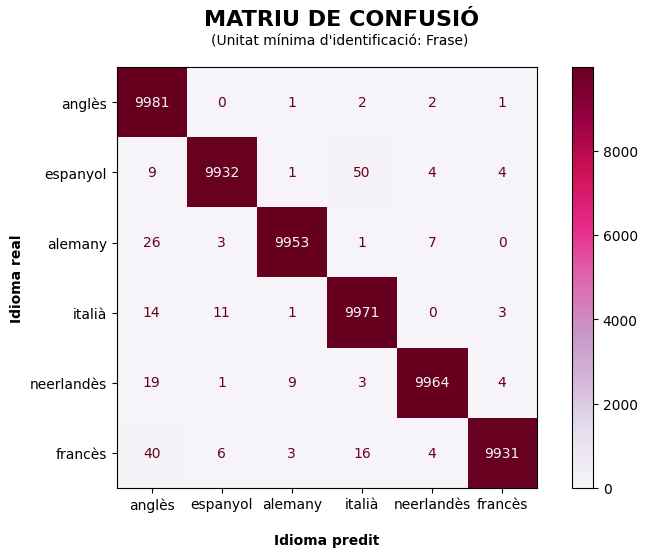

In [78]:
# Creació de la matriu de confusió
def mostra_matriu_confusio(y_true, y_pred, etiquetes):
    cm = confusion_matrix(y_true, y_pred, labels=etiquetes)
    fmt = 'd'
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=etiquetes)
    disp.plot(cmap='PuRd', ax=ax, values_format=fmt)
    plt.title("MATRIU DE CONFUSIÓ", fontweight='bold', y=1.08, x = 0.535, fontsize=16)
    plt.suptitle("(Unitat mínima d'identificació: Frase)", y=0.88, x = 0.56, fontsize=10)
    ax.set_xlabel("Idioma predit", fontweight='bold', labelpad=15)
    ax.set_ylabel("Idioma real", fontweight='bold')
    plt.tight_layout()
    plt.show()

# Preparació del conjunt de test per a la classificació
test_trigrames_conjunt = {
    "anglès": trigrames_frases_test_en,
    "espanyol": trigrames_frases_test_sp,
    "alemany": trigrames_frases_test_ger,
    "italià": trigrames_frases_test_it,
    "neerlandès": trigrames_frases_test_ner,
    "francès": trigrames_frases_test_fr
}

etiquetes = ["anglès", "espanyol", "alemany", "italià", "neerlandès", "francès"]

# Processament del test i generació de la matriu de confusió
y_true1, y_pred1 = processa_test_i_classifica(test_trigrames_conjunt, models_train)
mostra_matriu_confusio(y_true1, y_pred1, etiquetes)


La funció `mostra_matriu_confusio(y_true, y_pred, etiquetes)` té com a objectiu visualitzar la matriu de confusió generada a partir de les etiquetes reals i predites durant la classificació. Aquesta matriu ens mostra quantes frases han estat classificades correctament i quantes s’han confós entre els diferents idiomes.

Per construir-la, primer es calcula la matriu de confusió mitjançant la funció *confusion_matrix* de la llibreria *seaborn*, on es compara la classificació real (*y_true*) amb la predita (*y_pred*). Tot seguit, la matriu es visualitza utilitzant *ConfusionMatrixDisplay*.

In [79]:
from sklearn.metrics import accuracy_score

# Càlcul de l'accuracy
def calcula_accuracy(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    total_correctes = sum([1 for veritat, prediccio in zip(y_true, y_pred) if veritat == prediccio])
    print(f"\033[1mFrases correctament classificades:\033[0m {total_correctes} de {len(y_true)}")
    print(f"\033[1mPrecisió global (Accuracy):\033[0m {acc * 100:.2f}%")

calcula_accuracy(y_true1, y_pred1)

Frases correctament classificades: 59732 de 59977
Precisió global (Accuracy): 99.59%


La funció `calcula_accuracy(y_true, y_pred)` calcula i mostra la precisió global (accuracy) del model, indicant el percentatge de frases classificades correctament respecte al total. També mostra el nombre exacte de frases encertades per oferir una visió clara del rendiment global del sistema.

## **ANÀLISI DELS ERRORS EN LA CLASSIFICACIÓ D'IDIOMES**
---

Hem fet una anàlisi dels errors per entendre millor les dificultats del nostre model en la classificació d’idiomes i trobar maneres de millorar-ne la precisió. El que hem fet és identificar les oracions que han estat classificades incorrectament, analitzar quins idiomes es confonen més sovint i investigar les possibles causes d’aquests errors. Per això, hem examinat factors com els trigrames comuns entre idiomes, la longitud de les oracions i els casos en què el model ha tingut poca seguretat en la seva classificació.

### **ORACIONS MAL CLASSIFICADES**

In [80]:
# Funció per obtenir oracions mal classificades
def obtenir_oracions_mal_classificades(test_trigrames_conjunt, models_train):
    """
    Retorna un diccionari amb les oracions mal classificades per cada idioma.
    """
    from collections import defaultdict

    mal_classificades_per_idioma = defaultdict(list)

    for idioma, oracions_trigrames in test_trigrames_conjunt.items():
        for frase_trigrames in oracions_trigrames:
            probabilitats_idioma = calcula_probabilitats_per_frase(frase_trigrames, models_train)
            idioma_assignat = assigna_idioma(probabilitats_idioma)
           
            if idioma_assignat != idioma:
                mal_classificades_per_idioma[idioma].append({
                    'detectada_com': idioma_assignat,
                    'frase': frase_trigrames
                })

    return mal_classificades_per_idioma


def mostra_oracions_mal_classificades_per_idioma(mal_classificades_per_idioma):
    """
    Mostra les oracions mal classificades per cada idioma i el total de mal classificades.
    """
    total_mal_classificades = 0

    for idioma, errors in mal_classificades_per_idioma.items():
        total_mal_classificades += len(errors)
        print(f"\n\033[1m {len(errors)} oracions mal classificades per a l'idioma {idioma}:\033[0m")
        for entrada in errors:
            print(f"- Detectada com {entrada['detectada_com']}: {entrada['frase']}")

    print(f"\n\033[1mTOTAL DE oracions MAL CLASSIFICADES: {total_mal_classificades}\033[0m")
    return total_mal_classificades

mal_classificades = obtenir_oracions_mal_classificades(test_trigrames_conjunt, models_train)

total_mal_classificades = mostra_oracions_mal_classificades_per_idioma(mal_classificades)


 6 oracions mal classificades per a l'idioma anglès:
- Detectada com neerlandès: [((' ', ' ', 'c'), 1), ((' ', 'c', 'h'), 1), (('c', 'h', 'a'), 1), (('h', 'a', 'n'), 1), (('a', 'n', 'g'), 1), (('n', 'g', 'e'), 1), (('g', 'e', ' '), 1), (('e', ' ', 'i'), 1), ((' ', 'i', 't'), 1), (('i', 't', ' '), 1), (('t', ' ', 'h'), 1), ((' ', 'h', 'e'), 1), (('h', 'e', 'r'), 1), (('e', 'r', 'e'), 1), (('r', 'e', ' '), 1), (('e', ' ', 'd'), 1), ((' ', 'd', 'w'), 1), (('d', 'w', '.'), 1), (('w', '.', ' '), 1), (('.', ' ', ' '), 1)]
- Detectada com italià: [((' ', ' ', 'f'), 1), ((' ', 'f', 'a'), 1), (('f', 'a', 'r'), 1), (('a', 'r', 'l'), 1), (('r', 'l', 'e'), 1), (('l', 'e', 'y'), 1), (('e', 'y', '-'), 1), (('y', '-', 'b'), 1), (('-', 'b', 'e'), 1), (('b', 'e', 'r'), 1), (('e', 'r', 'e'), 1), (('r', 'e', 'n'), 1), (('e', 'n', 's'), 1), (('n', 's', ':'), 1), (('s', ':', ' '), 1), ((':', ' ', 'w'), 1), ((' ', 'w', 'e'), 1), (('w', 'e', "'"), 1), (('e', "'", 'r'), 1), (("'", 'r', 'e'), 1), (('r', 'e', 

La funció `obtenir_oracions_mal_classificades(test_trigrames_conjunt, models_train)` recorre totes les oracions del corpus de test i calcula la probabilitat per a cada idioma. Si l’idioma assignat pel model no coincideix amb l’idioma real, la frase es considera mal classificada i s’emmagatzema en un diccionari, agrupada per idioma real.

Posteriorment, la funció `mostra_oracions_mal_classificades_per_idioma(mal_classificades_per_idioma)` mostra per pantalla quantes oracions han estat mal classificades per a cada idioma, així com l’idioma amb què s’han confós. Això ens permet analitzar quines combinacions d’idiomes generen més errors i identificar possibles patrons de confusió.

### **DISTRIBUCIÓ DE CONFUSIÓ PER IDIOMA**

In [81]:
# Funció per mostrar la distribució de confusions per idioma
def distribucio_confusions_per_idioma(mal_classificades_per_idioma):
    """
    Mostra per a cada idioma amb quin altre idioma es confon més sovint i quantes vegades.
    """
    from collections import Counter

    print("\n\033[1mDISTRIBUCIÓ DE CONFUSIONS PER IDIOMA:\033[0m")
    for idioma, errors in mal_classificades_per_idioma.items():
        comptador_confusions = Counter([entrada['detectada_com'] for entrada in errors])
        print(f"\n\033[1mIDIOMA REAL:\033[0m {idioma}")
        for idioma_detectat, count in comptador_confusions.items():
            print(f"- Confós amb {idioma_detectat}: {count} vegades")
            
distribucio_confusions_per_idioma(mal_classificades)


DISTRIBUCIÓ DE CONFUSIONS PER IDIOMA:

IDIOMA REAL: anglès
- Confós amb neerlandès: 2 vegades
- Confós amb italià: 2 vegades
- Confós amb alemany: 1 vegades
- Confós amb francès: 1 vegades

IDIOMA REAL: espanyol
- Confós amb italià: 50 vegades
- Confós amb anglès: 9 vegades
- Confós amb alemany: 1 vegades
- Confós amb francès: 4 vegades
- Confós amb neerlandès: 4 vegades

IDIOMA REAL: alemany
- Confós amb espanyol: 3 vegades
- Confós amb anglès: 26 vegades
- Confós amb neerlandès: 7 vegades
- Confós amb italià: 1 vegades

IDIOMA REAL: italià
- Confós amb espanyol: 11 vegades
- Confós amb anglès: 14 vegades
- Confós amb francès: 3 vegades
- Confós amb alemany: 1 vegades

IDIOMA REAL: neerlandès
- Confós amb alemany: 9 vegades
- Confós amb anglès: 19 vegades
- Confós amb espanyol: 1 vegades
- Confós amb italià: 3 vegades
- Confós amb francès: 4 vegades

IDIOMA REAL: francès
- Confós amb anglès: 40 vegades
- Confós amb italià: 16 vegades
- Confós amb alemany: 3 vegades
- Confós amb neerl

La funció `distribucio_confusions_per_idioma(mal_classificades_per_idioma)` mostra, per a cada idioma real, amb quins altres idiomes s’ha confós i quantes vegades ha passat. Per fer-ho, recorre totes les frases mal classificades i utilitza un comptador per calcular la freqüència de cada confusió.

Aquesta funció és clau per entendre quins idiomes generen més errors entre si, cosa que pot indicar similituds lingüístiques o punts febles del model.

### **POSSIBLES MOTIUS PER LA CONFUSIÓ**

#### **1. TRIGRAMS COMUNS ENTRE IDIOMES**

In [82]:
from collections import Counter

def trigrames_comuns_entre_idiomes(models_train, idiomes_confosos, top_n=10):

    for idioma1, idioma2 in idiomes_confosos:
        print(f"\n\033[1mTRIGRAMES COMUNS MÉS FREQÜENTS ENTRE {idioma1} I {idioma2}:\033[0m")
       
        trigrames_idioma1 = Counter(models_train[idioma1])
        trigrames_idioma2 = Counter(models_train[idioma2])

        trigrames_comuns = set(trigrames_idioma1.keys()) & set(trigrames_idioma2.keys())

        trigrames_ordenats = sorted(trigrames_comuns, key=lambda trigram: trigrames_idioma1[trigram] + trigrames_idioma2[trigram], reverse=True)[:top_n]

        for trigram in trigrames_ordenats:
            freq_idioma1 = trigrames_idioma1[trigram]
            freq_idioma2 = trigrames_idioma2[trigram]
            print(f"Trigrama: {trigram} - Freqüència en {idioma1}: {freq_idioma1}, Freqüència en {idioma2}: {freq_idioma2}")

idiomes_confosos = [
    ('anglès', 'alemany'),
    ('anglès', 'italià'),
    ('anglès', 'neerlandès'),
    ('anglès', 'francès'),
    ('espanyol', 'anglès'),
    ('espanyol', 'alemany'),
    ('espanyol', 'italià'),
    ('espanyol', 'neerlandès'),
    ('espanyol', 'francès'),
    ('alemany', 'italià'),
    ('alemany', 'neerlandès'),
    ('italià', 'francès'),
    ('neerlandès', 'italià'),
    ('neerlandès', 'francès'),
    ('francès', 'alemany'),
]

trigrames_comuns_entre_idiomes(models_train, idiomes_confosos, top_n=10)


TRIGRAMES COMUNS MÉS FREQÜENTS ENTRE anglès I alemany:
Trigrama: ('e', 'n', ' ') - Freqüència en anglès: 0.0019222679537636066, Freqüència en alemany: 0.01648038332925392
Trigrama: ('.', ' ', ' ') - Freqüència en anglès: 0.008249176412004398, Freqüència en alemany: 0.008814917511929704
Trigrama: ('e', 'r', ' ') - Freqüència en anglès: 0.004156899282997222, Freqüència en alemany: 0.0125868274161239
Trigrama: (' ', 't', 'h') - Freqüència en anglès: 0.015419341975616367, Freqüència en alemany: 0.00019690159073511008
Trigrama: ('t', 'h', 'e') - Freqüència en anglès: 0.012702731340077461, Freqüència en alemany: 0.00025787186640028253
Trigrama: ('h', 'e', ' ') - Freqüència en anglès: 0.01116833409736285, Freqüència en alemany: 0.0012407598369059854
Trigrama: (' ', 'd', 'e') - Freqüència en anglès: 0.0016003972677918637, Freqüència en alemany: 0.008830822801233661
Trigrama: ('n', 'd', ' ') - Freqüència en anglès: 0.004933743001964982, Freqüència en alemany: 0.004460402751379416
Trigrama: (' 

La funció `trigrames_comuns_entre_idiomes(models_train, idiomes_confosos, top_n=10)` té com a objectiu identificar i mostrar els trigrames més freqüents que apareixen en ambdós idiomes d’una parella. Per aconseguir-ho, la funció rep com a paràmetres un diccionari amb els models de trigrames per idioma, una llista de parelles d’idiomes que s’han confós i el nombre de trigrames més freqüents que es volen visualitzar (top_n).
Per a cada parella d’idiomes, la funció identifica els trigrames compartits i calcula la seva freqüència combinada, sumant la freqüència de cada trigram en els dos idiomes. Posteriorment, es mostren els trigrames amb la freqüència més alta, fet que ens permet detectar patrons lingüístics similars que poden haver provocat errors de classificació.

#### **2. LONGITUD DE LES ORACIONS**

In [83]:
# Funció per a l'anàlisi de longitud de frase
def analisi_longitud_per_idioma(test_trigrames_conjunt, y_true, y_pred):
    estadistiques_longitud_per_idioma = {}

    for idioma, frases_trigrames in test_trigrames_conjunt.items():
        longitud_min = float('inf')
        longitud_max = 0

        for idx, frase_trigrames in enumerate(frases_trigrames):
            longitud = len(frase_trigrames)
            correcte = y_true[idx] == y_pred[idx]

            longitud_min = min(longitud_min, longitud)
            longitud_max = max(longitud_max, longitud)

            if idioma not in estadistiques_longitud_per_idioma:
                estadistiques_longitud_per_idioma[idioma] = {}

            if longitud not in estadistiques_longitud_per_idioma[idioma]:
                estadistiques_longitud_per_idioma[idioma][longitud] = {"total": 0, "correctes": 0, "incorrectes": 0}

            estadistiques_longitud_per_idioma[idioma][longitud]["total"] += 1
            if correcte:
                estadistiques_longitud_per_idioma[idioma][longitud]["correctes"] += 1
            else:
                estadistiques_longitud_per_idioma[idioma][longitud]["incorrectes"] += 1

        estadistiques_longitud_per_idioma[idioma]["longitud_min"] = longitud_min
        estadistiques_longitud_per_idioma[idioma]["longitud_max"] = longitud_max

    estadistiques_filtrades = {
        idioma: {
            longitud: stats
            for longitud, stats in longitud_stats.items()
            if isinstance(stats, dict) and stats["incorrectes"] > 0
        }
        for idioma, longitud_stats in estadistiques_longitud_per_idioma.items()
        if "longitud_min" in longitud_stats
    }

    return estadistiques_filtrades, estadistiques_longitud_per_idioma


estadistiques_longitud_filtrades, estadistiques_longitud_per_idioma = analisi_longitud_per_idioma(test_trigrames_conjunt, y_true1, y_pred1)

for idioma, longitud_stats in estadistiques_longitud_filtrades.items():
    print(f"\n\033[1mIDIOMA: {idioma}\033[0m")
    print(f"  \033[1mLongitud mínima: {estadistiques_longitud_per_idioma[idioma]['longitud_min']}\033[0m")
    print(f"  \033[1mLongitud màxima: {estadistiques_longitud_per_idioma[idioma]['longitud_max']}\033[0m")
    for longitud, stats in longitud_stats.items():
        print(f"  Longitud {longitud}: {stats['total']} frases, {stats['correctes']} correctes, {stats['incorrectes']} incorrectes")


IDIOMA: anglès
  Longitud mínima: 14
  Longitud màxima: 257
  Longitud 54: 55 frases, 54 correctes, 1 incorrectes
  Longitud 20: 12 frases, 11 correctes, 1 incorrectes
  Longitud 19: 9 frases, 8 correctes, 1 incorrectes
  Longitud 36: 23 frases, 22 correctes, 1 incorrectes
  Longitud 28: 18 frases, 17 correctes, 1 incorrectes
  Longitud 25: 21 frases, 20 correctes, 1 incorrectes

IDIOMA: espanyol
  Longitud mínima: 16
  Longitud màxima: 257
  Longitud 66: 52 frases, 51 correctes, 1 incorrectes
  Longitud 198: 44 frases, 43 correctes, 1 incorrectes
  Longitud 104: 52 frases, 51 correctes, 1 incorrectes
  Longitud 110: 60 frases, 59 correctes, 1 incorrectes
  Longitud 98: 53 frases, 52 correctes, 1 incorrectes
  Longitud 245: 26 frases, 25 correctes, 1 incorrectes

IDIOMA: alemany
  Longitud mínima: 17
  Longitud màxima: 257
  Longitud 104: 67 frases, 66 correctes, 1 incorrectes
  Longitud 193: 22 frases, 21 correctes, 1 incorrectes
  Longitud 165: 53 frases, 52 correctes, 1 incorrectes

La funció `analisi_longitud_per_idioma(test_trigrames_conjunt, y_true, y_pred)` analitza la relació entre la longitud de les frases i la precisió de la classificació. Per fer-ho, recorre totes les oracions del conjunt de test i calcula la seva longitud en nombre de trigrames.

Per a cada idioma, la funció registra les longituds mínimes i màximes de les frases presents en el conjunt de test i emmagatzema el nombre de frases correctament i incorrectament classificades segons la seva longitud. Finalment, filtra i mostra només aquelles longituds on s'han detectat errors, cosa que ens permet analitzar si les frases més curtes o més llargues tenen més probabilitat de ser mal classificades. Aquesta informació és útil per comprendre si la quantitat d’informació d’una frase influeix en la precisió del model.

#### **3. CLASSIFICACIONS INSEGURES**

In [84]:
def classificacions_insegures_per_idioma(test_trigrames_conjunt, models_train, llindar_inseguretat=0.1):
    frases_insegures_per_idioma = {idioma: [] for idioma in test_trigrames_conjunt.keys()}

    for idioma, frases_trigrames in test_trigrames_conjunt.items():
        for frase_trigrames in frases_trigrames:
            probabilitats_idioma = calcula_probabilitats_per_frase(frase_trigrames, models_train)
            
            probabilitats_ordenades = sorted(probabilitats_idioma.values(), reverse=True)
            
            if probabilitats_ordenades[0] - probabilitats_ordenades[1] < llindar_inseguretat:
                frases_insegures_per_idioma[idioma].append(frase_trigrames)

    return frases_insegures_per_idioma


frases_insegures_per_idioma = classificacions_insegures_per_idioma(test_trigrames_conjunt, models_train, llindar_inseguretat=0.5)

total_frases_insegures = 0

for idioma, frases in frases_insegures_per_idioma.items():
    total_frases_insegures += len(frases)  
    print(f"\n\033[1mIDIOMA: {idioma}\033[0m")
    print(f"  Total de frases insegures en {idioma}: {len(frases)}")
    for idx, frase in enumerate(frases, 1): 
        print(f"    Frase insegura {idx}: {frase}")

print(f"\n\033[1mTOTAL DE FRASES INSEGURES EN TOTS ELS IDIOMES: {total_frases_insegures} de les {total_mal_classificades} mal classificades\033[0m")


IDIOMA: anglès
  Total de frases insegures en anglès: 5
    Frase insegura 1: [((' ', ' ', 'c'), 1), ((' ', 'c', 'a'), 1), (('c', 'a', 'n'), 1), (('a', 'n', ' '), 1), (('n', ' ', 'l'), 1), ((' ', 'l', 'u'), 1), (('l', 'u', 'i'), 1), (('u', 'i', 's'), 1), (('i', 's', ' '), 1), (('s', ' ', 'd'), 1), ((' ', 'd', 'e'), 1), (('d', 'e', 'f'), 1), (('e', 'f', 'e'), 1), (('f', 'e', 'a'), 1), (('e', 'a', 't'), 1), (('a', 't', ' '), 1), (('t', ' ', 's'), 1), ((' ', 's', 'e'), 1), (('s', 'e', 'p'), 1), (('e', 'p', 'p'), 1), (('p', 'p', '?'), 1), (('p', '?', '.'), 1), (('?', '.', ' '), 1), (('.', ' ', ' '), 1)]
    Frase insegura 2: [((' ', ' ', 'c'), 1), ((' ', 'c', 'a'), 1), (('c', 'a', 'n'), 1), (('a', 'n', ' '), 1), (('n', ' ', 's'), 1), ((' ', 's', 'c'), 1), (('s', 'c', 'i'), 1), (('c', 'i', 'e'), 1), (('i', 'e', 'n'), 1), (('e', 'n', 't'), 1), (('n', 't', 'i'), 1), (('t', 'i', 's'), 1), (('i', 's', 't'), 1), (('s', 't', 's'), 1), (('t', 's', ' '), 1), (('s', ' ', 'e'), 1), ((' ', 'e', 'r'),

La funció `classificacions_insegures_per_idioma(test_trigrames_conjunt, models_train, llindar_inseguretat=0.1)` identifica les frases en què el model ha tingut poca seguretat en la classificació. Per fer-ho, calcula la probabilitat de cada idioma per a cada frase i mesura la diferència entre la probabilitat del primer i el segon idioma més probable. Si aquesta diferència és inferior al llindar establert, la frase es considera una classificació insegura i s’emmagatzema per idioma real.

El valor del llindar s’ha fixat en **0.1** perquè permet detectar casos en què el model dubta significativament entre dues opcions. Un llindar més alt podria incloure classificacions segures però amb poca diferència, mentre que un llindar massa baix només captaria casos extremadament incerts. Amb aquest valor, es capten classificacions amb ambigüitat rellevant, ajudant a analitzar situacions en què idiomes similars són difícils de distingir pel model.

<p style="text-align: justify;">

## **CONCLUSIONS DE L'ANÀLISI DELS ERRORS EN LA CLASSIFIACIÓ D'IDIOMES**
---
### 1. **Confusions més freqüents entre idiomes**  
   - L’idioma espanyol és el més afectat pels errors de classificació, amb 68 oracions mal classificades, de les quals una gran part han estat detectades com italià. Això indica una forta similitud entre aquests dos idiomes en el model.
   - L’anglès també ha patit errors, amb 6 casos de confusió, principalment amb neerlandès, italià, alemany i francès.
   - L’alemany ha estat mal classificat en 37 casos, en la majoria de situacions sent detectat com espanyol o anglès, cosa que reflecteix possibles influències en les estructures lingüístiques processades pel model.

### 2. **Patrons clars en la longitud de les frases mal classificades**  
   - En general, la longitud de les frases errònies no és gaire llarga. Això suggereix que les frases curtes tenen menys informació contextual i fan més difícil la classificació correcta per part del model.
   - Aquest patró és consistent en diversos idiomes, especialment en els casos en què l’anglès és confós amb neerlandès o italià, i quan l’espanyol es confon amb italià.

### 3. **Idiomes amb major taxa de confusió**  
   - La màxima taxa d’errors es troba entre l’espanyol i l’italià, fet que apunta a un gran solapament en els trigrames utilitzats per aquests idiomes.
   - Hi ha una presència notable d’errors en les frases curtes en anglès, on el model sovint les classifica erròniament com a neerlandès o alemany.
   - Les frases en alemany també es confonen sovint amb espanyol i anglès, fet que pot indicar que certes construccions sintàctiques tenen un efecte en la predicció del model.

### 4. **Punts de millora per reduir errors**  
   - **Ajustar la ponderació de trigrames comuns:** L’espanyol i l’italià tenen patrons similars que estan generant errors, i caldria ajustar la influència d’aquests trigrames per millorar la precisió.
   - **Pes específic per trigrames únics:** Incrementar el pes dels trigrames que són únics o menys freqüents per a cada idioma.
   - **Filtrat de trigrames comuns:** Excloure aquells trigrames que apareixen amb molta freqüència en diversos idiomes.
   - **Ajust de probabilitats:** Revisar la diferència de probabilitats entre el primer i segon idioma per detectar classificacions insegures.

Per tant, podem dir que, els errors observats es concentren en idiomes similars i frases curtes, la qual cosa indica que el model necessita millorar la diferenciació entre llengües properes i aprofitar millor el context lingüístic per evitar errors en frases amb poca informació.
<p>